In [317]:
import pyupbit as pub
from pyupbit import WebSocketManager
from scipy.optimize import minimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import os
import yaml
import time
from datetime import datetime

In [379]:
# 환경설정
os.makedirs('result', exist_ok=True)
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    ACCESS_KEY = config['ACCESS_KEY']
    SECRET_KEY = config['SECRET_KEY']
PAST = 60*3
FUTURE = 10
NUM = 200

In [344]:
# 티커 조회
tickers = pub.get_tickers()
tickers = np.array(list(filter(lambda x: x[:3] == 'KRW', tickers)))
# tickers = np.random.choice(tickers, size=10, replace=False)
tickers

array(['KRW-BTC', 'KRW-ETH', 'KRW-NEO', 'KRW-MTL', 'KRW-LTC', 'KRW-XRP',
       'KRW-ETC', 'KRW-OMG', 'KRW-SNT', 'KRW-WAVES', 'KRW-XEM',
       'KRW-QTUM', 'KRW-LSK', 'KRW-STEEM', 'KRW-XLM', 'KRW-ARDR',
       'KRW-ARK', 'KRW-STORJ', 'KRW-GRS', 'KRW-REP', 'KRW-ADA', 'KRW-SBD',
       'KRW-POWR', 'KRW-BTG', 'KRW-ICX', 'KRW-EOS', 'KRW-TRX', 'KRW-SC',
       'KRW-ONT', 'KRW-ZIL', 'KRW-POLY', 'KRW-ZRX', 'KRW-LOOM', 'KRW-BCH',
       'KRW-BAT', 'KRW-IOST', 'KRW-RFR', 'KRW-CVC', 'KRW-IQ', 'KRW-IOTA',
       'KRW-MFT', 'KRW-ONG', 'KRW-GAS', 'KRW-UPP', 'KRW-ELF', 'KRW-KNC',
       'KRW-BSV', 'KRW-THETA', 'KRW-QKC', 'KRW-BTT', 'KRW-MOC', 'KRW-ENJ',
       'KRW-TFUEL', 'KRW-MANA', 'KRW-ANKR', 'KRW-AERGO', 'KRW-ATOM',
       'KRW-TT', 'KRW-CRE', 'KRW-MBL', 'KRW-WAXP', 'KRW-HBAR', 'KRW-MED',
       'KRW-MLK', 'KRW-STPT', 'KRW-ORBS', 'KRW-VET', 'KRW-CHZ',
       'KRW-STMX', 'KRW-DKA', 'KRW-HIVE', 'KRW-KAVA', 'KRW-AHT',
       'KRW-LINK', 'KRW-XTZ', 'KRW-BORA', 'KRW-JST', 'KRW-CRO', 'KRW-TON',
     

In [351]:
# result = []
# for ticker in tickers:
#     # 기초데이터 수집
#     price = pub.get_ohlcv(ticker, interval='minute1', count=PAST, period=1)['close']

#     # 데이터 가공
#     r_t = price.diff().shift(-1).iloc[:-1]/price[:-1]
#     dr_t = r_t.diff().shift(-1).iloc[:-1]

#     # 모수 추정
#     def obj_func(p):
#         a, b, sigma = p
#         loglik = np.log(norm.pdf(x=dr_t-a*(b-r_t.iloc[:-1]), loc=0, scale=sigma)).sum()
#         return -loglik

#     a, b, sigma = minimize(obj_func, (1.0, -0.0001, 0.002), method='Nelder-Mead').x

#     # 손실 확률
#     t = FUTURE
#     r0 = r_t.iloc[-2]
#     mean = r0*np.exp(-a*t)+b*(1-np.exp(-a*t))
#     std = np.sqrt(sigma**2/(2*a)*(1-np.exp(-2*a*t)))
#     prob_profit = 1-norm.cdf(x=0.005, loc=mean, scale=std)
#     result.append((ticker, prob_profit))
#     time.sleep(0.005)
# prob_profit = pd.DataFrame(result, columns=['ticker', 'prob_profit']).sort_values(by='prob_profit', ascending=False)
# prob_profit

,ticker,prob_profit
49,KRW-BTT,3.894853e-01
59,KRW-MBL,7.220519e-02
38,KRW-IQ,5.541608e-02
64,KRW-STPT,5.318921e-02
10,KRW-XEM,4.378393e-02
...,...,...
5,KRW-XRP,5.773160e-15
42,KRW-GAS,2.220446e-15
6,KRW-ETC,1.110223e-16
101,KRW-XEC,1.110223e-16


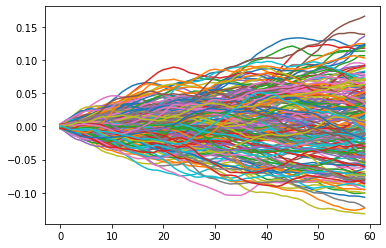

In [499]:
# 기초데이터 수집
price = pub.get_ohlcv(ticker, interval='minute1', count=PAST, period=1)['close']

# 데이터 가공
r_t = price.diff().shift(-1).iloc[:-1]/price[:-1]
dr_t = r_t.diff().shift(-1).iloc[:-1]

# 모수 추정
def obj_func(p):
    a, b, sigma = p
    loglik = np.log(norm.pdf(x=dr_t-a*(b-r_t.iloc[:-1]), loc=0, scale=sigma)).sum()
    return -loglik

a, b, sigma = minimize(obj_func, (1.0, -0.0001, 0.002), method='Nelder-Mead').x

# 손실 확률
t = FUTURE
r0 = r_t.iloc[-2]
dt = 10/60
rt = np.zeros([NUM, int(FUTURE/dt)+1])
rt[:, 0] = r0
dw = norm.rvs(size=(NUM, int(FUTURE/dt)), loc=0, scale=np.sqrt(dt))
for i in range(dw.shape[1]):
    rt[:, i+1] = rt[:, i] + a*(b-rt[:, i])*dt + sigma*dw[:, i]
rt = rt[:, 1:]
cum_rt = np.cumprod(1+rt, axis=1)-1

# (cum_rt <= 0.005).sum(axis=0)
plt.plot(cum_rt.T)

In [497]:

prob_profit = pd.DataFrame(result, columns=['ticker', 'prob_profit']).sort_values(by='prob_profit', ascending=False)
prob_profit

,ticker,prob_profit
49,KRW-BTT,3.894853e-01
59,KRW-MBL,7.220519e-02
38,KRW-IQ,5.541608e-02
64,KRW-STPT,5.318921e-02
10,KRW-XEM,4.378393e-02
...,...,...
5,KRW-XRP,5.773160e-15
42,KRW-GAS,2.220446e-15
6,KRW-ETC,1.110223e-16
101,KRW-XEC,1.110223e-16


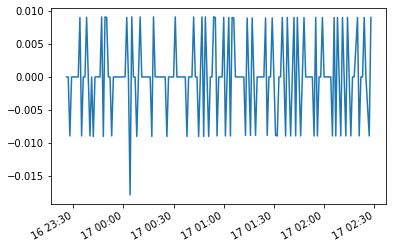

In [354]:
price = pub.get_ohlcv('KRW-MBL', interval='minute1', count=PAST, period=1)['close']
# 데이터 가공
r_t = price.diff().shift(-1).iloc[:-1]/price[:-1]
dr_t = r_t.diff().shift(-1).iloc[:-1]
r_t.plot()
plt.show()

In [355]:
# # bid(매수호가) / ask(매도호가)
# orderbook = pub.get_orderbook('KRW-BTC')
# orderbook_df = pd.DataFrame(orderbook['orderbook_units'])
# orderbook_df

In [69]:
ubapi = ub.Upbit(ACCESS_KEY, SECRET_KEY)

In [77]:
# 매도 주문 - 지정가
ubapi.sell_limit_order(ticker='KRW-ETH', price=3237000, volume=0.00246407)

{'uuid': '115fcc2a-4cba-4bda-a324-54b8f992f6b1',
 'side': 'ask',
 'ord_type': 'limit',
 'price': '3237000.0',
 'state': 'wait',
 'market': 'KRW-ETH',
 'created_at': '2022-03-12T18:42:08+09:00',
 'volume': '0.00246407',
 'remaining_volume': '0.00246407',
 'reserved_fee': '0.0',
 'remaining_fee': '0.0',
 'paid_fee': '0.0',
 'locked': '0.00246407',
 'executed_volume': '0.0',
 'trades_count': 0}

In [89]:
# 매도 주문 - 시장가
# ubapi.sell_market_order(ticker='KRW-ETH', volume=0.00246407)

{'uuid': 'f25b5a17-59f8-4488-882b-5c004b4062e8',
 'side': 'ask',
 'ord_type': 'market',
 'price': None,
 'state': 'wait',
 'market': 'KRW-ETH',
 'created_at': '2022-03-12T18:53:54+09:00',
 'volume': '0.00246407',
 'remaining_volume': '0.00246407',
 'reserved_fee': '0.0',
 'remaining_fee': '0.0',
 'paid_fee': '0.0',
 'locked': '0.00246407',
 'executed_volume': '0.0',
 'trades_count': 0}

In [90]:
# 주문 조회
ubapi.get_order('KRW-ETH')

[]

In [78]:
# 주문 취소
ubapi.cancel_order('115fcc2a-4cba-4bda-a324-54b8f992f6b1')

{'uuid': '115fcc2a-4cba-4bda-a324-54b8f992f6b1',
 'side': 'ask',
 'ord_type': 'limit',
 'price': '3237000.0',
 'state': 'wait',
 'market': 'KRW-ETH',
 'created_at': '2022-03-12T18:42:08+09:00',
 'volume': '0.00246407',
 'remaining_volume': '0.00246407',
 'reserved_fee': '0.0',
 'remaining_fee': '0.0',
 'paid_fee': '0.0',
 'locked': '0.00246407',
 'executed_volume': '0.0',
 'trades_count': 0}